### Mccreight - suffixlinks
Mccreight enables us to contruct a suffixtree in linear time O(n). This is done by switching between a fast and slow search for when looking if a current suffix fits into the tree. this is done by using a suffix link. the link in short allows us to jump to where a suffix should be inserted instead of looking through the tree from the root again

[0, 7, 4, 1, 10, 6, 3, 5, 2, 9, 8, 11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Visualization saved as Suffix_tree_MC_compressed.png


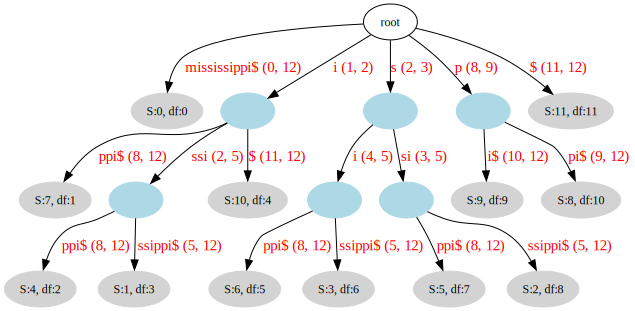

In [ ]:
from graphviz import Digraph
import os

class SuffixTreeNode_mc:
    def __init__(self):
        self.start = -1             #start index of edge label
        self.end = -1               #end index of edge label
        self.children = {}          #key: edge label, value: chilnode
        self.suffix_link = None     #link to another node (allows you to 'jump' in he tree)
        self.suffix_number = None   #suffix numbering for leaves

class SuffixTree_mc:
    def __init__(self, string):
        self.string = string + "$"
        self.root = SuffixTreeNode_mc()
        self.active_node = self.root        #active node = controler to navigate the tree
        self.active_edge = 0                #idx of start char being looked at
        self.active_length = 0              #length of currentl matched part
        self.remaining_suffix_count = 0
        self.last_created_node = None
        self.suffix_number = 0
        self.construct_tree()

    def construct_tree(self):       # for every i -> run add suffix
        for i in range(len(self.string)):
            self.add_suffix(i)

    def add_suffix(self, pos):       
        self.last_created_node = None       # reset last created node
        self.remaining_suffix_count += 1

        while self.remaining_suffix_count > 0:  # while there are suffixes to add
            if self.active_length == 0:
                self.active_edge = pos

            #check if the edge starting with the active_edge character exists
            if self.string[self.active_edge] not in self.active_node.children:        # no child matched - so we make a new node for it
                new_node = SuffixTreeNode_mc()
                new_node.start = pos                                                  # starts in current position
                new_node.end = len(self.string)                                       # leaf so ends at end of stirng
                new_node.suffix_number = self.suffix_number
                self.suffix_number += 1
                self.active_node.children[self.string[self.active_edge]] = new_node
                

                # setup suffix link from last created internal node (if not none)
                if self.last_created_node is not None:
                    self.last_created_node.suffix_link = self.active_node
                    self.last_created_node = None # reset last created node

            else:   # we do have an to follow edge!
                next_node = self.active_node.children[self.string[self.active_edge]]
                edge_length = next_node.end - next_node.start

                if self.active_length >= edge_length:   # active_length longer than edge, we move active node up
                    self.active_edge += edge_length
                    self.active_length -= edge_length
                    self.active_node = next_node
                    continue
                
                # character on edge matches, so we move along it
                if self.string[next_node.start + self.active_length] == self.string[pos]:
                    self.active_length += 1
                    #if a new node was waiting for a suffix link, set it now
                    if self.last_created_node is not None:
                        self.last_created_node.suffix_link = self.active_node
                        self.last_created_node = None
                    break

                # mismatch on edge: split the edge and create a new internal node and leafnode
                split_node = SuffixTreeNode_mc()
                split_node.start = next_node.start
                split_node.end = next_node.start + self.active_length
                self.active_node.children[self.string[self.active_edge]] = split_node

                new_leaf = SuffixTreeNode_mc()
                new_leaf.start = pos
                new_leaf.end = len(self.string)
                split_node.children[self.string[pos]] = new_leaf

                next_node.start += self.active_length
                split_node.children[self.string[next_node.start]] = next_node

                new_leaf.suffix_number = self.suffix_number     # assign and increment suffix number
                self.suffix_number += 1

                if self.last_created_node is not None:
                    self.last_created_node.suffix_link = split_node

                self.last_created_node = split_node

            self.remaining_suffix_count -= 1

            if self.active_node == self.root and self.active_length > 0:
                self.active_length -= 1
                self.active_edge = pos - self.remaining_suffix_count + 1
            elif self.active_node != self.root:
                self.active_node = self.active_node.suffix_link     # move the active node to the suffixlink

#########################
##### Visualization #####
    def visualize(self, filename="Suffix_tree_MC_compressed"):
        """
        Visualize the suffix tree using graphviz and save it as a PNG file.
        Internal nodes will have 'None' and leaves will display their suffix numbers.
        """
        dot = Digraph(node_attr={'shape': 'ellipse', 'fontsize': '12', 'fixedsize': 'false'},
                    edge_attr={'fontsize': '15', 'fontcolor': 'red', 'labelfontsize': '10', 
                                'labeldistance': '1', 'labelangle': '0'})
        self.add_edges(dot, self.root, node_id="root")
        dot.render(os.path.join("Trees/", filename), format='png', cleanup=True)    # saves an image of the tree in the root folder
        print(f"Visualization saved as {filename}.png")
        return dot

    def add_edges(self, dot, node, node_id):
        """
        Recursively add edges and nodes to the graph, with suffix numbers for leaf nodes and 'None' for internal nodes.
        """
        for i, (char, child) in enumerate(node.children.items()):
            child_id = f"{node_id}_{i}"  # unique id for each child node

            # check if df_numbering has been added
            if hasattr(child, 'df_number'):
                if not child.children:
                    leaf_label = f"S:{child.suffix_number}, df:{child.df_number}"
                    dot.node(child_id, leaf_label, style="filled", color="lightgrey")
                else:
                    dot.node(child_id, "", style="filled", color="lightgrey")  # Internal nodes remain unlabeled
            else:
                # Determine the label for the node (suffix number for leaves, 'None' for internal nodes)
                if not child.children:  # If the node is a leaf
                    # Leaf node - show suffix number
                    label = f"S:{child.suffix_number}"  # Suffix index (suffix number)
                    dot.node(child_id, label, style="filled", color="lightgrey")
                else:  # Internal node
                    label = ""  # Internal nodes display 'None'
                    dot.node(child_id, label, style="filled", color="lightblue")

            # Edge label: display the string from start to end index
            edge_label = self.string[child.start:child.end] + f" ({child.start}, {child.end})"
            dot.edge(node_id, child_id, label=edge_label)

            # Recursively add edges for the child node
            self.add_edges(dot, child, child_id)

   
################################
##### validation functions ##### 
    def find_longest_branch(self):
        """
        Using DFS to find the longest branch in the suffix tree.
        Returns both the longest string and the corresponding length.
        """
        def dfs(node, current_path):
            if not node.children:
                return current_path
            
            longest_branch = current_path
            for child in node.children.values():
                edge_label = self.string[child.start:child.end]
                branch = dfs(child, current_path + edge_label)
                if len(branch) > len(longest_branch):
                    longest_branch = branch
            return longest_branch

        # start traversal
        return dfs(self.root, "")

    def get_all_suffixes(self):
        """
        using dfs we look through the tree to find all the suffixes
        returns a list of all suffixes found throughout the constructed tree
        """
        suffixes = []
        def dfs(node, current_path):
            if not node.children:
                return suffixes.append(current_path) # leaf node, so we add suffix

            for child in node.children.values(): # look at
                edge_label = self.string[child.start:child.end]
                dfs(child, current_path + edge_label) # recussively search tree

        dfs(self.root, "") # initiate search
        return suffixes
    
    def count_outgoing_edges(self):
        """
        Count the number of outgoing edges for internal nodes. internal nodes can minimum have 2 
        children, and at max have the same as number of unique symbols in the stirng.
        Returns nodes that fail these criteria
        """
        # define criteria
        min_children = 2
        max_children = len(set(self.string))    # length of unique char in the string        
        failed_nodes = []                       # keep track of failed nodes

        # depth first search
        def dfs(node):
            if not node.children: # no children, so its a leaf
                return 

            for child in node.children.values():
                dfs(child) # recursively move out branch

            # check if number of children is correct
            num_children = len(node.children)
            if num_children < min_children or num_children > max_children:
                failed_nodes.append(node)
            return
        
        dfs(self.root)
        return failed_nodes

    def check_unique_children(self):
        """
        check that each internal node has unique values in the dictionary for children
        Returns a list of failed nodes, if empty all passed.
        """
        failed_nodes = []

        def dfs(node):
            if not node.children: # no children, so its a leaf
                return 
            
            for child in node.children.values():
                dfs(child) # recursively move out branch

            # check if all children are unique
            all_children = list(node.children.values())
            unique_children = set(all_children)
            unique_check = len(all_children) == len(unique_children)
            if unique_check == False:
                failed_nodes.append(node)

        dfs(self.root)
        return failed_nodes
    
    def node_visits(self):
        """
        Find number of times we visist a given node with a depth-first approach. 
        We should only visit each node once.
        Returns a list of failed nodes
        """
        visit_counts = {}
        failed_nodes = []

        def dfs(node):
            #recursively visit all children
            for child in node.children.values():
                dfs(child)

            if node in visit_counts:
                visit_counts[node] += 1
            else:
                visit_counts[node] = 1

            if visit_counts[node] > 1:
                failed_nodes.append(node)            
            
        dfs(self.root) # initialize recursion
        return failed_nodes


############################
##### helper functions #####

    def df_numbering(self):
        """
        The recursive version above gave some issues during testing, so a iterative version using a stack was made instead
        """
        count = 0
        df_list = []
        s_list = []
        
        stack = [(self.root, None, None)]  # #stack to store (current node, parent min_df, parent max_df)
        visited_children = {}  # Map each node to the index of the next child to visit
        
        while stack: #ends when stack is empty
            node, min_df, max_df = stack.pop()
            
            if not node.children:  # leafndoe
                node.df_number = count
                node.leaf_range = (count, count)
                df_list.append(node.df_number)
                s_list.append(node.suffix_number)
                count += 1
                continue
            
            # Initialize visited children tracking for each internal node on first visit
            if node not in visited_children:
                visited_children[node] = 0
                min_df, max_df = float("inf"), -float("inf")
            
            # Process the next child of the current node
            children = list(node.children.values())
            if visited_children[node] < len(children):
                child = children[visited_children[node]]
                visited_children[node] += 1
                # Push the node back to stack to revisit after its child is processed
                stack.append((node, min_df, max_df))
                # Push child to stack for further processing
                stack.append((child, None, None))
            else:
                #update min and max depthfirst numbers for internal nodes after visiting all children
                for child in children:
                    min_df = min(min_df, child.leaf_range[0])
                    max_df = max(max_df, child.leaf_range[1])
                node.leaf_range = (min_df, max_df)
        
        return s_list, df_list

test_string = "mississippi"

# test string define in earlier implementation
suffix_tree_mc = SuffixTree_mc(test_string)
s_list, df_list = suffix_tree_mc.df_numbering()
print(s_list)
print(df_list)
suffix_tree_mc.visualize()

## validate the trees

In [43]:
def validate_suffix_tree(input_string, verbose = True):
    """
    collective function to use all the validation functions at the same time
    Returns a list where the indices corospond to the follow:
    ["input_string", "length_check", "spell_check", "all_same_suffix_check"]
    Verbose indicates if an output should be printed or if only the list should be returned
    """
    
    string_s = input_string + "$"
    suffix_tree = SuffixTree_mc(input_string)

    #### Find longest branch in suffix tree ##### + spellcheck
    longest_branch = suffix_tree.find_longest_branch()
    output_length= len(longest_branch)
    input_length = len(string_s)

    #### Double check every suffix is in tree ####
    actual_suffixes = sorted(suffix_tree.get_all_suffixes())
    expected_suffixes = sorted([string_s[i:] for i in range(len(string_s))])

    #### count edges ####
    failed_count_edges = suffix_tree.count_outgoing_edges()
    count_check = False
    if failed_count_edges == []:
        count_check = True

    #### unique children ####
    failed_unique_children = suffix_tree.check_unique_children()
    unique_child_check = False
    if failed_unique_children == []:
        unique_child_check = True

    #### Node visits during depth-first search ####
    too_many_visits = suffix_tree.node_visits()
    visits_check = False
    if too_many_visits == []:
        visits_check = True

    if verbose == True:
        print("suffix_tree was generated with the string:  ", input_string)
        print("same length?  ", output_length == input_length)
        #### Spell checking ####
        print("spelled correctly?  ", longest_branch == string_s)
        print("obs suffixes:  ", actual_suffixes)
        print("exp suffixes:  ", expected_suffixes)
        print("All suffixes same?  ", actual_suffixes == expected_suffixes)
        print("All internal nodes have correct number of children?  ", count_check)
        print("All internal nodes have unique children?  ", unique_child_check)
        print("All nodes were only visited once?  ", visits_check)


    return [input_string, 
            output_length==input_length, 
            longest_branch == string_s, 
            actual_suffixes == expected_suffixes,
            count_check,
            unique_child_check,
            visits_check]


string = "aaaaaaaaa"
validate_suffix_tree(string, verbose=True)

suffix_tree was generated with the string:   aaaaaaaaa
same length?   True
spelled correctly?   True
obs suffixes:   ['$', 'a$', 'aa$', 'aaa$', 'aaaa$', 'aaaaa$', 'aaaaaa$', 'aaaaaaa$', 'aaaaaaaa$', 'aaaaaaaaa$']
exp suffixes:   ['$', 'a$', 'aa$', 'aaa$', 'aaaa$', 'aaaaa$', 'aaaaaa$', 'aaaaaaa$', 'aaaaaaaa$', 'aaaaaaaaa$']
All suffixes same?   True
All internal nodes have correct number of children?   True
All internal nodes have unique children?   True
All nodes were only visited once?   True


['aaaaaaaaa', True, True, True, True, True, True]

In [44]:
import random 

def random_input_string(n, symbols):
    """
    creates a string of the specified length n with randomly selected symbols from the allowed
    ones indicated by symbols.
    """
    return ''.join(random.choice(symbols) for i in range(n))

test_duration = 10000
n = 100
symbols = 'agct'

for i in range(test_duration):
    string = random_input_string(n, symbols)
    
    checks = validate_suffix_tree(string, verbose=False)
    len_check = checks[1]
    spell_check = checks[2]
    suffix_check = checks[3]
    count_check = checks[4]
    child_check = checks[5]
    visits_check = checks[6]

    # if any check fails break loop and report
    if len_check == False or spell_check == False or suffix_check == False or count_check == False or child_check == False or visits_check == False:
        print("Test failed with:", string)
        print("length:", len_check)
        print("spelling:", spell_check)
        print("suffix_check:", suffix_check)
        print("count_check:", count_check)
        print("unique child check:", child_check)
        print("visits check:", visits_check)
        break

# if nothing is returned, there is no complaints

## Runtime test

In [45]:
import time 

def measure_time(func, *args, **kwargs):
    """
    Measure the time it takes to run a function
    """
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return elapsed_time, result

In [46]:
# import functions from other scripts
from suffixtree_construction import *

### Testcase: only a's string

In [71]:
import matplotlib.pyplot as plt

#Size of input strings
string_lengths_a = range(100, 10000, 1000)  

runtimes_func1_a = []
runtimes_func1_a_n = []
runtimes_func1_a_n2 = []
runtimes_func2_a = []
runtimes_func2_a_n = []
runtimes_func2_a_n2 = []


for length in string_lengths_a:
    test_string = 'a' * length  #generate only a string
    
    #measure for SuffixTree
    runtime_1, suffix_tree = measure_time(SuffixTree, test_string)
    runtimes_func1_a.append(runtime_1)
    runtimes_func1_a_n.append(runtime_1/length)
    runtimes_func1_a_n2.append(runtime_1/(length*length))

    #measure for SuffixTree_mc
    runtime_2, suffix_tree = measure_time(SuffixTree_mc, test_string)
    runtimes_func2_a.append(runtime_2)
    runtimes_func2_a_n.append(runtime_2/length)
    runtimes_func2_a_n2.append(runtime_2/(length*length))

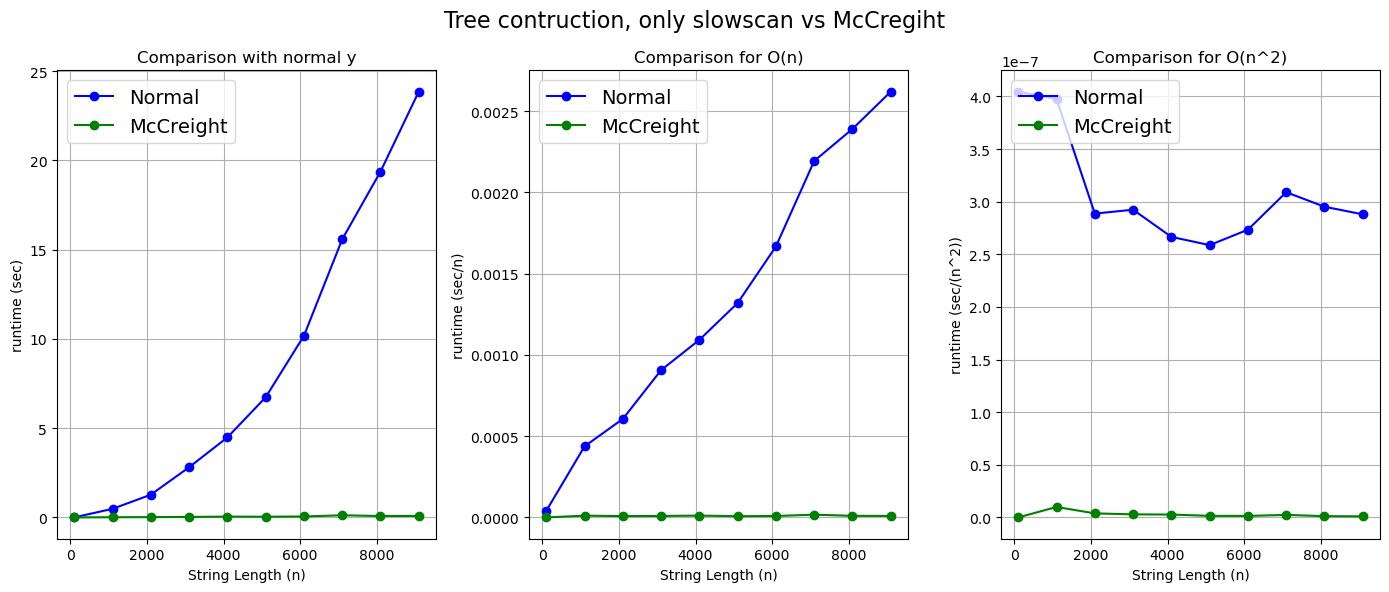

In [ ]:
#create subplots:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
fig.suptitle('Tree contruction, only slowscan vs McCregiht', fontsize=16)


# plot1 - y unmanipulated
axes[0].plot(string_lengths_a, runtimes_func1_a, marker='o', color='blue', label="Normal")
axes[0].plot(string_lengths_a, runtimes_func2_a, marker='o', color='green', label="McCreight")
axes[0].set_title('Comparison with normal y')
axes[0].set_xlabel('String Length (n)')
axes[0].set_ylabel('runtime (sec)')
# axes[0].set_ylim(0, 0.2)
axes[0].grid(True)
axes[0].legend(fontsize = 14, loc = "upper left")


# plot2 - y divided by n
axes[1].plot(string_lengths_a, runtimes_func1_a_n, marker='o', color='blue', label="Normal")
axes[1].plot(string_lengths_a, runtimes_func2_a_n, marker='o', color='green', label="McCreight")
axes[1].set_title('Comparison for O(n)')
axes[1].set_xlabel('String Length (n)')
axes[1].set_ylabel('runtime (sec/n)')
# axes[1].set_ylim(0, 0.00005)
axes[1].grid(True)
axes[1].legend(fontsize = 14, loc = "upper left")


# plot3 - y divided by n^2
axes[2].plot(string_lengths_a, runtimes_func1_a_n2, marker='o', color='blue', label="Normal")
axes[2].plot(string_lengths_a, runtimes_func2_a_n2, marker='o', color='green', label="McCreight")
axes[2].set_title('Comparison for O(n^2)')
axes[2].set_xlabel('String Length (n)')
axes[2].set_ylabel('runtime (sec/(n^2))')
axes[2].grid(True)
# axes[2].set_ylim(0, 0.00000002)
axes[2].legend(fontsize = 14, loc = "upper left")


#adjust layout to avoid overlap
plt.tight_layout()
# plt.savefig("Plots/Tree_construction_comparison_MC_v1.png", dpi = 300)
plt.show()

### Testcase: random string

In [88]:
import matplotlib.pyplot as plt

#Size of input strings
string_lengths_random = range(100, 20000, 1000)  
alphabet = "atgc"

runtimes_func1_random = []
runtimes_func1_random_n = []
runtimes_func1_random_n2 = []
runtimes_func2_random = []
runtimes_func2_random_n = []
runtimes_func2_random_n2 = []


for length in string_lengths_random:
    test_string = random_input_string(length, alphabet)  #generate only a string
    
    #measure for SuffixTree
    runtime_1, suffix_tree = measure_time(SuffixTree, test_string)
    runtimes_func1_random.append(runtime_1)
    runtimes_func1_random_n.append(runtime_1/length)
    runtimes_func1_random_n2.append(runtime_1/(length*length))

    #measure for SuffixTree_mc
    runtime_2, suffix_tree = measure_time(SuffixTree_mc, test_string)
    runtimes_func2_random.append(runtime_2)
    runtimes_func2_random_n.append(runtime_2/length)
    runtimes_func2_random_n2.append(runtime_2/(length*length))

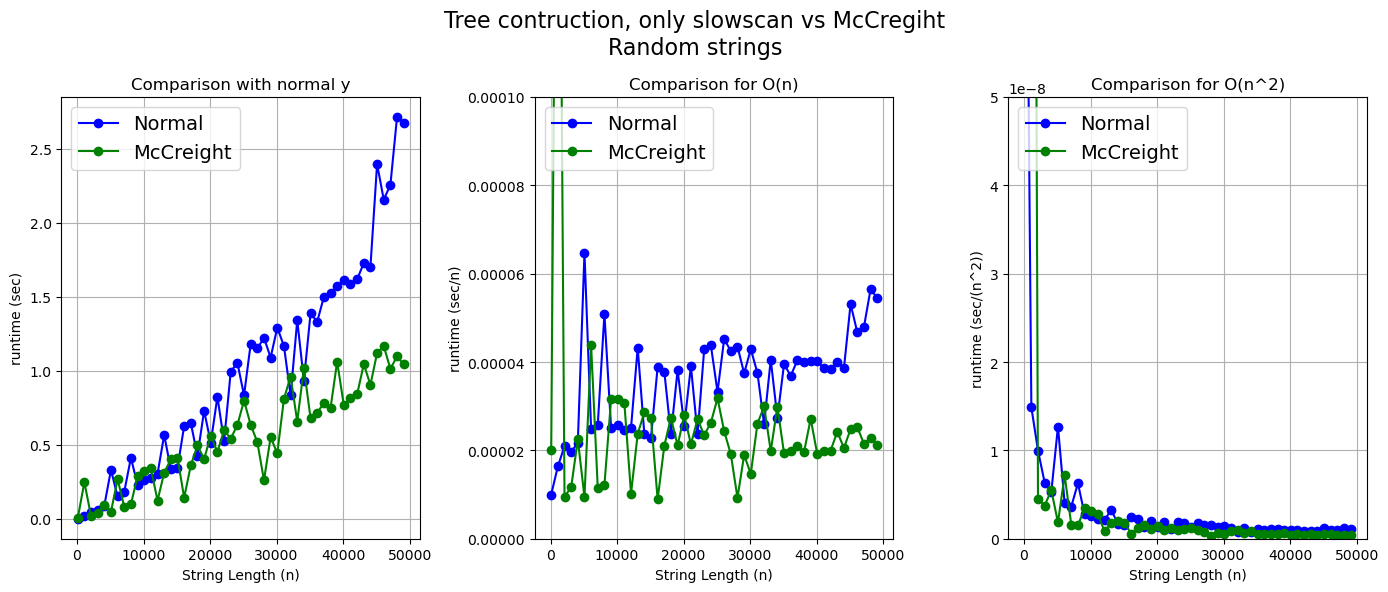

In [ ]:
#create subplots:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
fig.suptitle('Tree contruction, only slowscan vs McCregiht\nRandom strings', fontsize=16)


# plot1 - y unmanipulated
axes[0].plot(string_lengths_random, runtimes_func1_random, marker='o', color='blue', label="Normal")
axes[0].plot(string_lengths_random, runtimes_func2_random, marker='o', color='green', label="McCreight")
axes[0].set_title('Comparison with normal y')
axes[0].set_xlabel('String Length (n)')
axes[0].set_ylabel('runtime (sec)')
# axes[0].set_ylim(0, 0.2)
axes[0].grid(True)
axes[0].legend(fontsize = 14, loc = "upper left")


# plot2 - y divided by n
axes[1].plot(string_lengths_random, runtimes_func1_random_n, marker='o', color='blue', label="Normal")
axes[1].plot(string_lengths_random, runtimes_func2_random_n, marker='o', color='green', label="McCreight")
axes[1].set_title('Comparison for O(n)')
axes[1].set_xlabel('String Length (n)')
axes[1].set_ylabel('runtime (sec/n)')
axes[1].set_ylim(0, 0.0001)
axes[1].grid(True)
axes[1].legend(fontsize = 14, loc = "upper left")


# plot3 - y divided by n^2
axes[2].plot(string_lengths_random, runtimes_func1_random_n2, marker='o', color='blue', label="Normal")
axes[2].plot(string_lengths_random, runtimes_func2_random_n2, marker='o', color='green', label="McCreight")
axes[2].set_title('Comparison for O(n^2)')
axes[2].set_xlabel('String Length (n)')
axes[2].set_ylabel('runtime (sec/(n^2))')
axes[2].grid(True)
axes[2].set_ylim(0, 0.00000005)
axes[2].legend(fontsize = 14, loc = "upper left")


#adjust layout to avoid overlap
plt.tight_layout()
# plt.savefig("Plots/Tree_construction_comparison_MC_vRandom.png", dpi = 300)
plt.show()

### Include repeat search
The repeat search function was originally made for the slower suffix tree construction, so it needs to be adapted alittle and cannot just be imported. Specificly the call of df.numbering for the tree has changed



In [61]:
from repeat_search_speedup import *

def repeat_search_speedup(self):
    """
    Faster version of repeat_search. Finds the largest leaflist of children, and avoids using
    i as leaves in this Large(v). additionally does checks for j and not just i.
    Returns a list of (i_suf, depth) which starts a BTR

    Doctest examples:
        >>> repeat_searcg(SuffixTree("abaabaabbba"))
        [(2, 1), (5, 1), (2, 3), (8, 1)]
    """
    S = self.string
    s_list, df_list = self.df_numbering()

    suff_idx_dict = index_dict(s_list, df_list)
    df_idx_dict = index_dict(df_list, s_list)

    BTR_list = []

    def dfs(node, current_path):
        if not node.children: #base: no children so leaf
            return
        
        largest_child = (None, 0) # (node_id, size) , keeps track of largest child
        
        #recursively visit all nodes
        for child in node.children.values():
            edge_label = self.string[child.start:child.end]             # gather the edge label, so we keep track of current path/depth
            dfs(child, current_path + edge_label)
            
            child_size = child.leaf_range[1]-child.leaf_range[0] + 1    # +1 since we want all leaves inside the node and not just difference
            if child_size > largest_child[1]:
                largest_child = (child, child_size)
        
        # 2a - get leaflist (from the node numbering function)
        leaf_list = (node.leaf_range)
        depth = len(current_path) # uses current path to find depth of current node

        if depth != 0: # 0 would be at root
            #determine small(v) and large(v)
            large_v = largest_child[0].leaf_range # define large(v)
            small_v = sub_range(leaf_list, large_v) # define small(v)

            if small_v[0] == None:      # large is in first part of total range
                checks_in_leaflists(BTR_list, S, depth, leaf_list, large_v, small_v[1], suff_idx_dict, df_idx_dict)
            elif small_v[1] == None:    # large is in later part of total range
                checks_in_leaflists(BTR_list, S, depth, leaf_list, large_v, small_v[0], suff_idx_dict, df_idx_dict)
            else:                       # large is in the middel of total range
                checks_in_leaflists(BTR_list, S, depth, leaf_list, large_v, small_v[0], suff_idx_dict, df_idx_dict)
                checks_in_leaflists(BTR_list, S, depth, leaf_list, large_v, small_v[1], suff_idx_dict, df_idx_dict)

    dfs(self.root, "") # initialize recursion
    return BTR_list

suffix_tree = SuffixTree_mc("ABAABAABBBA")
suffix_tree.df_numbering()

print(repeat_search_speedup(suffix_tree))

[(2, 3), (5, 1), (2, 1), (8, 1)]


In [62]:
def left_turn(S, BTR_list):
    S = S + '$'
    repeats = []

    for i in BTR_list:        
        length = i[1]
        x = i[0]            # start idx
        y = i[0]+length     # start of 2nd part of repeat
        while S[x] == S[y] and x >= 0:
            repeats.append((x, length))
            x = x-1
            y = y-1
    return repeats

In [51]:
import random

def find_btr(seq):
    """
    finds all BTRs within a given string
    """
    seq = seq + "$"
    btrs = []
    n = len(seq)
    for length in range(1, n // 2 + 1):  # search all possible lengths
        for i in range(n - 2 * length + 1):  # every possible repeat pair
            repeat1 = seq[i:i+length]
            repeat2 = seq[i+length:i+2*length]
            if repeat1 == repeat2:
                if i+2*length < n and seq[i+1:i+length+1] != seq[i+length+1:i+2*length+1]: # check shift to the right is no longer a repeat
                    btrs.append((i, length))
    return btrs

find_btr("ABAABAABBBA")

[(2, 1), (5, 1), (8, 1), (2, 3)]

In [63]:
# lets try and run on alot more strings at a time
num_of_strings = 1000
len_of_strings = random.randint(30,100)
alphabet = "atgc"

random_strings = [random_input_string(len_of_strings, alphabet) for _ in range(num_of_strings)]

# BTRs for each string
btrs_per_string = [find_btr(s) for s in random_strings]

# BTRs using the suffix tree
btrs_per_suffixtree = []
for s in random_strings:
    suffix_tree = SuffixTree_mc(s)
    search_result = repeat_search_speedup(suffix_tree)
    btrs_per_suffixtree.append(search_result)

for i, s in enumerate(random_strings):
    if sorted(btrs_per_string[i]) != sorted(btrs_per_suffixtree[i]): # Not same we stop and report it
        print(f"FAILED with string {i+1}: {s}")
        break

# runs without issue means everything ran as expected

### Combine the functions and compare to brute force

In [64]:
import matplotlib.pyplot as plt
import math

#Size of input strings
string_lengths = range(100, 3000, 100)  


runtimes_func1 = []
runtimes_func2 = []

for length in string_lengths:
    test_string = random_input_string(length, symbols='atgc')
    
    #measure for SuffixTree
    runtime_1, suffix_tree = measure_time(SuffixTree_mc, test_string)
    runtimes_func1.append(runtime_1/length)
    suffix_tree.df_numbering()
    #measure for repeat_search
    runtime_2, btr_repeats = measure_time(repeat_search_speedup, suffix_tree)
    runtimes_func2.append(runtime_2/(length*math.log(length)))

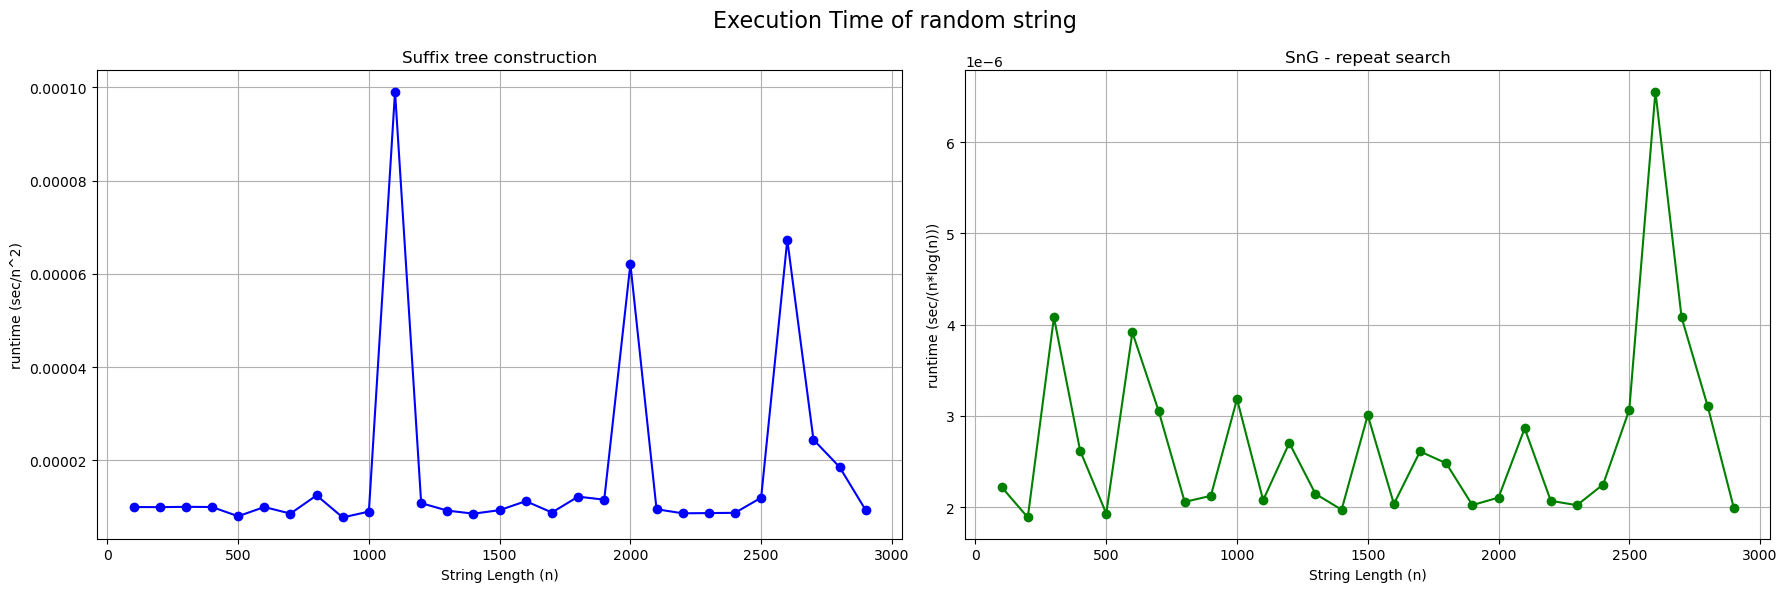

In [54]:

#create subplots: 
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Execution Time of random string', fontsize=16)


# plot1
axes[0].plot(string_lengths, runtimes_func1, marker='o', color='blue')
axes[0].set_title('Suffix tree construction')
axes[0].set_xlabel('String Length (n)')
axes[0].set_ylabel('runtime (sec/n^2)')
axes[0].grid(True)

# plot2
axes[1].plot(string_lengths, runtimes_func2, marker='o', color='green')
axes[1].set_title('SnG - repeat search')
axes[1].set_xlabel('String Length (n)')
axes[1].set_ylabel('runtime (sec/(n*log(n)))')
axes[1].grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [68]:
# import brute force function 
from find_all_repeats import find_repeats


#Size of input strings
string_lengths = range(100, 5000, 100)  


runtimes_naive = []
runtimes_suffix = []

for length in string_lengths:
    test_string = random_input_string(length, symbols='atgc')
    
    ### measure naive algo    
    runtimes1, repeats_naive = measure_time(find_repeats, test_string)
    runtimes_naive.append(runtimes1)


    ### measure for SuffixTree procedure
    runtimes2_1, suffix_tree_mc = measure_time(SuffixTree_mc, test_string) 
    runtimes2_2, btrs = measure_time(repeat_search_speedup, suffix_tree_mc)
    runtimes2_3, repeats = measure_time(left_turn, test_string, btrs)

    runtimes_suffix.append(runtimes2_1+runtimes2_2+runtimes2_3)

    ### ensure that the results are the same
    if len(repeats_naive) !=  len(repeats):
       print("The lists of repeats were not the same")
       print(f"Find_repeats: {repeats_naive}\nSuffixtree: {repeats}")
       break

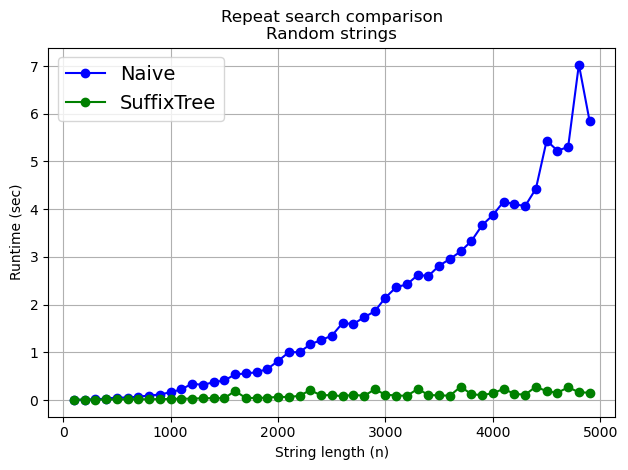

In [ ]:
plt.plot(string_lengths, runtimes_naive, marker='o', color='blue', label = 'Naive')
plt.plot(string_lengths, runtimes_suffix, marker='o', color='green', label = 'SuffixTree')
plt.title("Repeat search comparison\nRandom strings")
plt.xlabel('String length (n)')
plt.ylabel('Runtime (sec)')
plt.legend(fontsize = 14, loc = "upper left")
plt.grid(True)

plt.tight_layout()
#plt.savefig("Plots/full_repeat_search_comparison_MC.png", dpi = 300)      # save the plot
plt.show()